In [ ]:
!python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU (UUID: GPU-e2f26f7a-e23a-8611-7bac-98a3e82d1c41)


In [1]:
from helper_functions import plot_loss_curves, create_tensorboard_callback, compare_historys

## Use TensorFlow dataset to download data

In [2]:
# get tensorflow datasets
import tensorflow_datasets as tfds

In [3]:
# List all available datasets
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


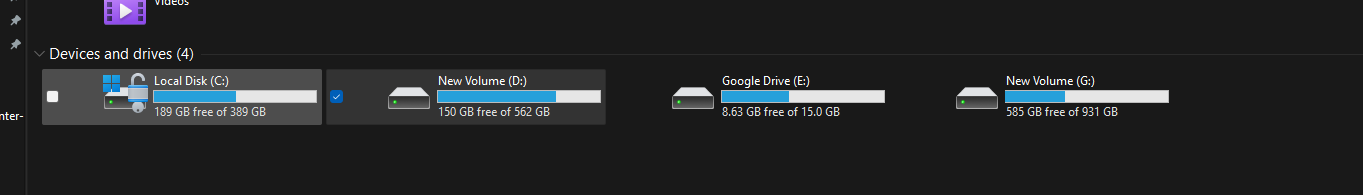

In [4]:
# load in the data (takes 5-6 minutes in data)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                            split=["train", "validation"],
                                             data_dir="G:\\Datasets",
                                            shuffle_files=True,
                                            as_supervised=True, # Data get returns in tuple format
                                            with_info=True,
                                            download=False)  # Make this True to download data again

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling G:\Datasets\food101\2.0.0.incompleteY1SKDK\food101-train.tfrecord*...:   0%|          | 0/75750 [00:…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling G:\Datasets\food101\2.0.0.incompleteY1SKDK\food101-validation.tfrecord*...:   0%|          | 0/25250…

Dataset food101 downloaded and prepared to G:\Datasets\food101\2.0.0. Subsequent calls will reuse this data.


In [5]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the food101 data from TFDS

In [35]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # Samples are in format (image_tensor, label)

In [36]:
# Look at training data
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [37]:
# Outpput info about out training sample
for image, label in train_one_sample:
    print(f"""
        Image Shape: {image.shape},
        Image datatype: {image.dtype},
        Target class from Food101: {label},
        Class Name (str form): {class_names[label.numpy()]}
    """)


        Image Shape: (384, 512, 3),
        Image datatype: <dtype: 'uint8'>,
        Target class from Food101: 56,
        Class Name (str form): huevos_rancheros
    


In [38]:
# Look at the image
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [144,  81, 102],
        [142,  78, 102],
        [139,  75,  99]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [159,  96, 115],
        [154,  89, 111],
        [146,  83, 104]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [162,  98, 114],
        [162,  95, 113],
        [157,  93, 110]],

       ...,

       [[ 75,  32,  16],
        [ 77,  34,  17],
        [ 78,  35,  19],
        ...,
        [ 99,  31,  20],
        [104,  32,  20],
        [106,  34,  20]],

       [[ 81,  34,  18],
        [ 81,  34,  16],
        [ 82,  35,  19],
        ...,
        [102,  33,  26],
        [104,  36,  27],
        [109,  39,  31]],

       [[ 79,  30,  13],
        [ 80,  31,  14],
        [ 81,  32,  15],
        ...,
        [113,  46,  4

In [39]:
# Get  Min and Max values of image
import tensorflow as tf

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TFDS

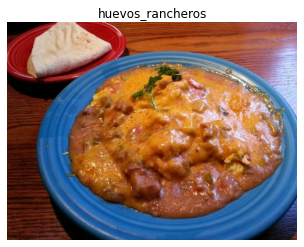

In [40]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

In [41]:
# Mak a function for preprocessing images

def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype to 'float32' and reshapes image to [img_shape, img_shape, colour_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # Reshaping target image
    return tf.cast(image, tf.float32), label

In [43]:
# Preprocess a single sample image
preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img, preprocessed_img.shape

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         ...,
         [157.23973 ,  91.24997 , 110.18368 ],
         [150.2857  ,  86.622444, 107.239784],
         [144.57637 ,  80.47435 , 103.6325  ]],
 
        [[  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         ...,
         [157.85226 ,  91.70941 , 105.097206],
         [164.45404 ,  97.72448 , 114.3112  ],
         [159.09677 ,  93.16319 , 110.545815]],
 
        [[  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         [  0.      ,   0.      ,   0.      ],
         ...,
         [156.04575 ,  86.47431 ,  96.6886  ],
         [156.88269 ,  89.311264, 100.668434],
         [151.5303  ,  83.95888 ,  97.173164]],
 
        ...,
 
        [[ 66.50514 ,  29.862257

## Batch and prepare datasets

In [45]:
#  Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turnit into batches and prefetch it (to load it faster)
train_data = train_data.shuffle(buffer_size=2000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [46]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

In [47]:
checkpoint_path = "tfds_food101/checkpoint.ckpt"
modeling_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_freq="epoch",
                                                        monitor="val_accuracy",
                                                        save_best_only=True,
                                                        save_weights_only=True,
                                                        verbose=0)

## Setup mixed precision training

In [48]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision policy

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


## Build feature extraction model

In [156]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pooling")(x)
# x = layers.Dense(1001)(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

In [157]:
# Compile the model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=2300, decay_rate=0.9)

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
             metrics=["accuracy"])

In [158]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 dense_6 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

## Checking layer dtype policy

In [151]:
for layer in model.layers:
    print(layer.name, layer.dtype, layer.trainable, layer.dtype_policy)

input_layer float32 True <Policy "float32">
efficientnetb0 float32 False <Policy "mixed_float16">
global_avg_pooling float32 True <Policy "mixed_float16">
dense_4 float32 True <Policy "mixed_float16">
dense_5 float32 True <Policy "mixed_float16">
softmax_float32 float32 True <Policy "float32">


In [152]:
# Check the same for layers of base_model
for layer in model.layers[1].layers[:10]:
    print(layer.name, layer.dtype, layer.dtype_policy)

input_5 float32 <Policy "float32">
rescaling_4 float32 <Policy "mixed_float16">
normalization_4 float32 <Policy "mixed_float16">
stem_conv_pad float32 <Policy "mixed_float16">
stem_conv float32 <Policy "mixed_float16">
stem_bn float32 <Policy "mixed_float16">
stem_activation float32 <Policy "mixed_float16">
block1a_dwconv float32 <Policy "mixed_float16">
block1a_bn float32 <Policy "mixed_float16">
block1a_activation float32 <Policy "mixed_float16">


## Fitting the model

In [159]:
# Creating early stopping callbacks
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=1, restore_best_weights=True)

In [160]:
history_feature_extraction = model.fit(train_data,
                                      epochs=5,
                                       steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)),
                                      callbacks=[modeling_checkpoint, create_tensorboard_callback(dir_name="tfds_food101_project",
                                                                                                 experiment_name="feature_extraction"), early_stop_callback])

Saving TensorBoard log files to: tfds_food101_project/feature_extraction/20220619-225643
Epoch 1/5
2368/2368 [==============================] - 96s 39ms/step - loss: 1.8243 - accuracy: 0.5561 - val_loss: 1.2376 - val_accuracy: 0.6740
Epoch 2/5
2368/2368 [==============================] - 95s 40ms/step - loss: 1.2960 - accuracy: 0.6659 - val_loss: 1.1377 - val_accuracy: 0.6999
Epoch 3/5
2368/2368 [==============================] - 95s 40ms/step - loss: 1.1480 - accuracy: 0.7029 - val_loss: 1.0891 - val_accuracy: 0.7095
Epoch 4/5
2368/2368 [==============================] - 97s 41ms/step - loss: 1.0556 - accuracy: 0.7271 - val_loss: 1.0669 - val_accuracy: 0.7111
Epoch 5/5
2368/2368 [==============================] - 96s 40ms/step - loss: 0.9877 - accuracy: 0.7443 - val_loss: 1.0516 - val_accuracy: 0.7190


In [161]:
model.evaluate(test_data)

790/790 [==============================] - 25s 31ms/step - loss: 1.0530 - accuracy: 0.7171


[1.052994728088379, 0.7170693278312683]

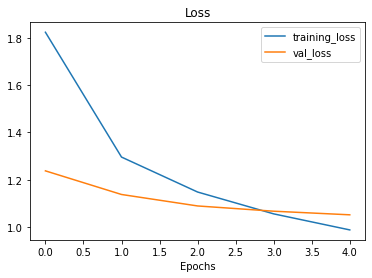

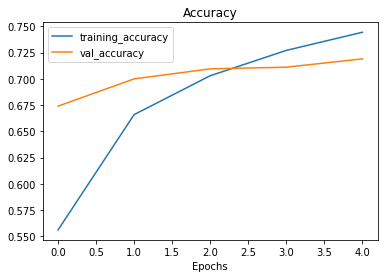

In [162]:
plot_loss_curves(history_feature_extraction)

## Fine tuning base model

In [193]:
# making last 10 layers of base model trainable
base_model.trainable = True

# for layer in base_model.layers[:-7]:
#     layer.trainable = False

In [194]:
# Take a look at layers for confirmation
for layer in base_model.layers[-15:]:
    print(layer.name, layer.trainable)

block7a_expand_bn True
block7a_expand_activation True
block7a_dwconv True
block7a_bn True
block7a_activation True
block7a_se_squeeze True
block7a_se_reshape True
block7a_se_reduce True
block7a_se_expand True
block7a_se_excite True
block7a_project_conv True
block7a_project_bn True
top_conv True
top_bn True
top_activation True


In [195]:
# Recompiling the model
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=2300, decay_rate=0.9)

model.compile(loss="sparse_categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             metrics=["accuracy"])

In [196]:
# Check model summary for trainable parameters
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 dense_6 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-tra

In [197]:
# Creating early stopping callbacks
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

In [198]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [200]:
# Fiting the model
initial_epochs = 5

history_fine_tuning = model.fit(train_data,
                               epochs=initial_epochs + 5,
                               steps_per_epoch=len(train_data),
                               validation_data=test_data,
                               validation_steps=int(0.15 * len(test_data)),
                               initial_epoch=history_feature_extraction.epoch[-1],
                               callbacks=[create_tensorboard_callback(dir_name="tfds_food101_project", experiment_name="fine_tuning"), early_stop_callback, reduce_lr])

Saving TensorBoard log files to: tfds_food101_project/fine_tuning/20220620-001012
Epoch 5/10
2368/2368 [==============================] - 292s 123ms/step - loss: 0.0920 - accuracy: 0.9700 - val_loss: 1.7110 - val_accuracy: 0.7248 - lr: 1.0000e-04
Epoch 6/10
2368/2368 [==============================] - 295s 124ms/step - loss: 0.0757 - accuracy: 0.9754 - val_loss: 1.8302 - val_accuracy: 0.7238 - lr: 1.0000e-04
Epoch 7/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.0653 - accuracy: 0.9782
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 293s 123ms/step - loss: 0.0653 - accuracy: 0.9782 - val_loss: 1.7159 - val_accuracy: 0.7524 - lr: 1.0000e-04
Epoch 8/10
2368/2368 [==============================] - 292s 123ms/step - loss: 0.0097 - accuracy: 0.9972 - val_loss: 1.7151 - val_accuracy: 0.7632 - lr: 2.0000e-05


In [201]:
model.evaluate(test_data)

790/790 [==============================] - 26s 32ms/step - loss: 1.7058 - accuracy: 0.7592


[1.7057771682739258, 0.7592079043388367]

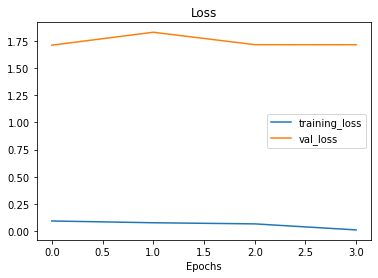

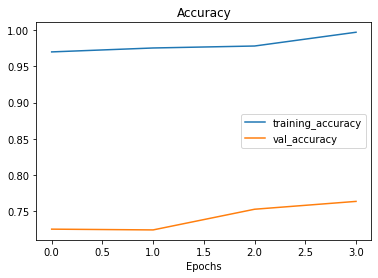

In [202]:
plot_loss_curves(history_fine_tuning)

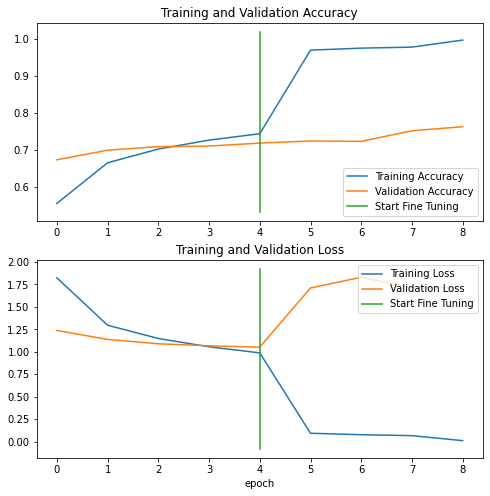

In [203]:
compare_historys(history_feature_extraction, history_fine_tuning, 5)